<a href="https://colab.research.google.com/github/jchen8000/MLDLwithPython/blob/main/4_04_KMeans_Clustering/Color_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Color Quantization

Install OpenCV packages:

In [1]:
%pip install \
  numpy==2.0.2 \
  opencv-python==4.12.0.88 \
  opencv-contrib-python==4.12.0.88 \
  opencv-python-headless==4.12.0.88 \
  scikit-learn==1.6.1 \
  matplotlib==3.10.0 \
  pillow==11.3.0

In [2]:
import numpy as np
import sklearn
from sklearn.datasets import load_sample_image
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from PIL import Image

In [3]:
def get_distinct_colours(image: np.ndarray) -> int:
    """
    Count the number of distinct colors in an RGB or RGBA image.

    Parameters
    ----------
    image : np.ndarray
        Input image with shape (H, W, 3) or (H, W, 4).

    Returns
    -------
    int
        Number of unique colors (including alpha if present).
    """
    if image.ndim != 3 or image.shape[2] not in (3, 4):
        raise ValueError("Expected image with shape (H, W, 3) or (H, W, 4).")

    # Flatten pixels into rows of color components
    pixels = image.reshape(-1, image.shape[-1])

    # Find unique colors
    unique_colors = np.unique(pixels, axis=0)

    return unique_colors.shape[0]


In [4]:
def color_quantization(image: np.ndarray, clusters: int) -> np.ndarray:
    """
    Quantize colors in an RGB or RGBA image using k-means clustering (OpenCV).

    - If the input is RGBA (shape HxWx4), the alpha channel is preserved.
    - Clustering is performed on the RGB channels only.
    - Returns an array with the same dtype and shape as the input.

    Parameters
    ----------
    image : np.ndarray
        Input image as a uint8 ndarray with shape (H, W, 3) or (H, W, 4).
    clusters : int
        Number of color clusters (k) for k-means.

    Returns
    -------
    np.ndarray
        Quantized image (same shape and dtype as input).
    """
    if image.ndim != 3 or image.shape[2] not in (3, 4):
        raise ValueError("Expected image with shape (H, W, 3) or (H, W, 4).")

    # Separate alpha (if present)
    has_alpha = (image.shape[2] == 4)
    if has_alpha:
        rgb = image[..., :3]
        alpha = image[..., 3]
    else:
        rgb = image

    # Prepare data for k-means (float32)
    X = rgb.reshape((-1, 3)).astype(np.float32)

    # OpenCV k-means criteria: stop when either max iterations or epsilon reached
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Run k-means (k-means++ centers for stability)
    # ret: compactness; label: per-point cluster indices; center: cluster centers (RGB)
    ret, label, center = cv2.kmeans(
        X, clusters, None, criteria, 10, cv2.KMEANS_PP_CENTERS
    )

    # Map each pixel to its cluster center and reshape back to image
    center = center.astype(np.uint8)
    quant_rgb = center[label.flatten()]
    quant_rgb = quant_rgb.reshape(rgb.shape)

    # Reattach alpha if the input had it
    if has_alpha:
        quant_image = np.dstack((quant_rgb, alpha))
    else:
        quant_image = quant_rgb

    return quant_image


## A sample color palette

the below code is modified from
https://matplotlib.org/stable/gallery/color/named_colors.html

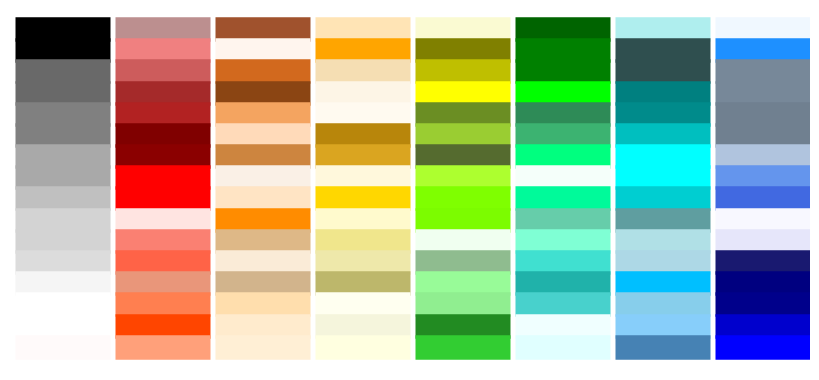

In [5]:
NCOLS = 8
NROWS = 16
FIGSIZE = (8, 6)

# --- Get and sort colors by HSV (as tuples for safe sorting) ---
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
sorted_names = sorted(
    colors.keys(),
    key=lambda name: tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(colors[name])[:3]))
)

# --- Create plot ---
fig, ax = plt.subplots(figsize=FIGSIZE)
X, Y = fig.get_size_inches() * fig.dpi  # pixel dimensions
h = Y / (NROWS + 1)
w = X / NCOLS

for i, name in enumerate(sorted_names):
    row = i % NROWS
    col = i // NROWS
    y = Y - row * h - h

    xi = w * (col + 0.05)
    xf = w * (col + 1.0)

    ax.hlines(
        y + h * 0.1,
        xi, xf,
        color=colors[name],
        linewidth=h * 0.5
    )

# --- Clean up axes ---
ax.set_xlim(0, X)
ax.set_ylim(0, Y)
ax.axis('off')
ax.margins(0)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.4, hspace=0, wspace=0)

plt.show()

# --- Export as image ---
fig.canvas.draw()

# Try RGBA first (modern backends), fall back to RGB
try:
    buf = fig.canvas.buffer_rgba()
    color_palette = np.asarray(buf)  # shape: (height, width, 4)
    mode = 'RGBA'
except Exception:
    rgb = fig.canvas.tostring_rgb()
    width, height = fig.canvas.get_width_height()
    color_palette = np.frombuffer(rgb, dtype=np.uint8).reshape((height, width, 3))
    mode = 'RGB'

Image.fromarray(color_palette).save('color_palette.png')


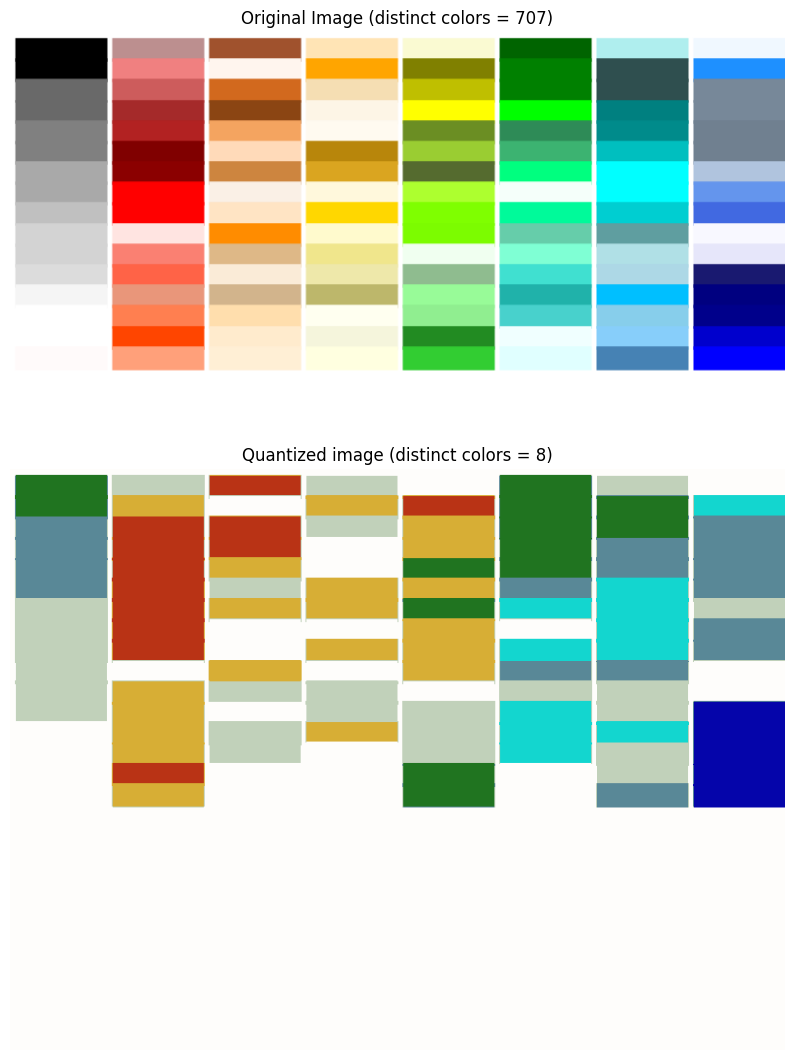

In [6]:
# color_palette = cv2.imread('color_palette.png')
dist_color = get_distinct_colours(color_palette)
fig = plt.figure(figsize=(10, 16))
plt.subplot(2, 1, 1)
plt.title(f"Original Image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(color_palette)

k = 8
img_k8 = color_quantization(color_palette, k)
dist_color = get_distinct_colours(img_k8)
# fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.title(f"Quantized image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img_k8)
plt.subplots_adjust(hspace=-0.45)
plt.savefig("color_palette_Quantized.png", format="png", transparent=True, bbox_inches='tight')
plt.show()

## Color Wheel, for color quantization

Generate a color wheel:

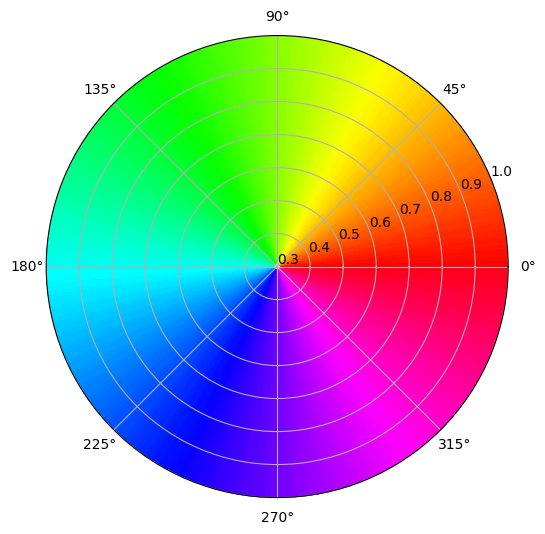

In [7]:
def create_color_wheel_data(r_min=0.3, r_max=1.0, n_theta=360):
    """Generate meshgrid data for color wheel."""
    t = np.linspace(0, 2*np.pi, n_theta)
    r = np.linspace(r_min, r_max, 50)
    return np.meshgrid(r, t)

def plot_color_wheel(ax, r_min=0.3, r_max=1.0, cmap_name='hsv'):
    """Plot color wheel on a polar axis."""
    colormap = plt.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(0.0, 2*np.pi)

    r_grid, t_grid = create_color_wheel_data(r_min, r_max)
    ax.pcolormesh(t_grid, r_grid, t_grid, norm=norm, cmap=colormap, shading='nearest')
    ax.set_ylim(r_min, r_max)

    return ax

def display_color_wheel(save_path=None, r_min=0.3, r_max=1.0, cmap_name='hsv'):
    """Create color wheel for display with labels and grid, optionally save to file."""
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    plot_color_wheel(ax, r_min, r_max, cmap_name)
    ax.grid(True)

    # Save to file if path is provided
    if save_path:
        fig.savefig(save_path, dpi=100, bbox_inches='tight', facecolor='white')

    plt.show()
    plt.close(fig)
    return fig, ax

def generate_color_wheel(r_min=0.3, r_max=1.0, cmap_name='hsv', figsize=(3, 3)):
    """Create clean color wheel without decorations for post-processing."""
    fig = plt.figure(figsize=figsize, facecolor='white')
    canvas = FigureCanvasAgg(fig)

    # Full canvas axes with polar projection
    ax = fig.add_axes([0, 0, 1, 1], projection='polar', facecolor='white')

    # Plot color wheel
    plot_color_wheel(ax, r_min, r_max, cmap_name)

    # Remove all decorations
    ax.set_axis_off()

    # Convert to RGBA array
    canvas.draw()
    rgba_array = np.array(canvas.buffer_rgba())
    plt.close(fig)

    return rgba_array

# --- 1. Display the color wheel and optionally save it ---
display_color_wheel(save_path='color_wheel.png')

# --- 2. Generate clean color wheel for post-processing ---
color_wheel = generate_color_wheel(r_min=0.3, r_max=1.0)

# print(f"Clean color wheel array shape: {color_wheel.shape}")
# print(f"Clean color wheel dtype: {color_wheel.dtype}")


Apply K-Means on the color wheel for color quantization for $k = 32, 16, 8$

Display:

> Original Image
>
> Quantized image fro $k=32$
>
> Quantized image fro $k=16$
>
> Quantized image fro $k=8$

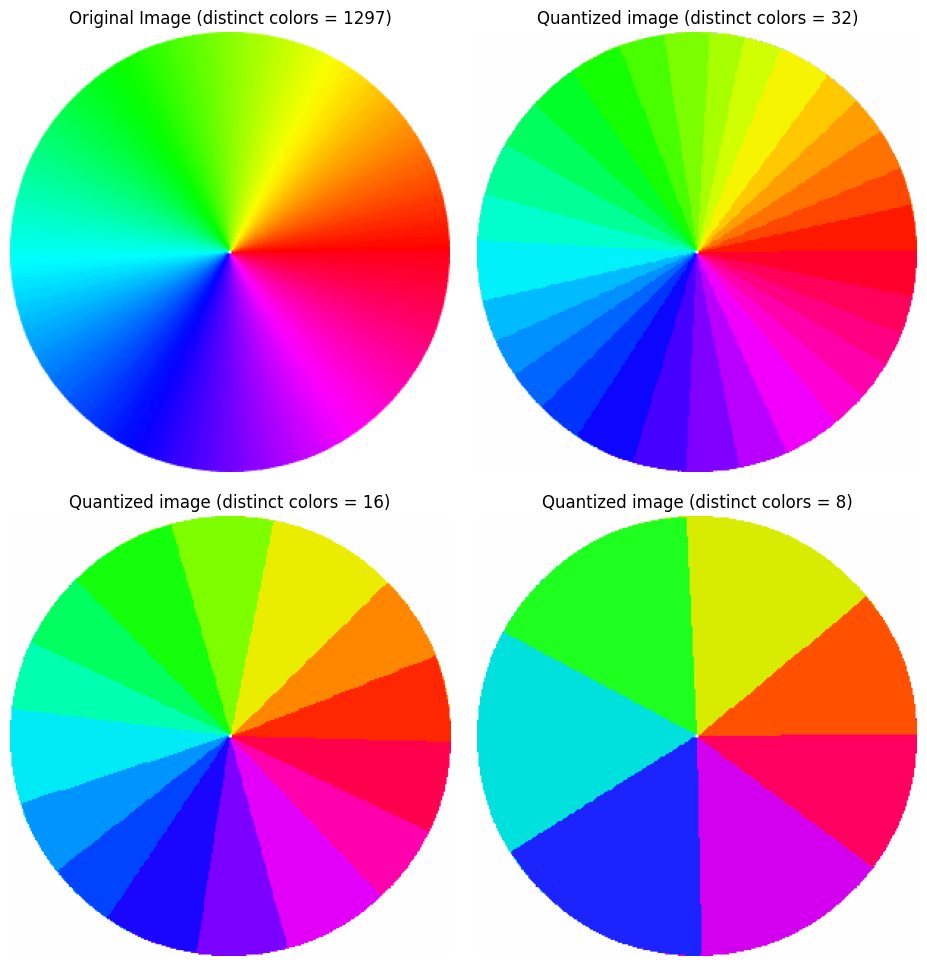

In [8]:
dist_color = get_distinct_colours(color_wheel)
fig = plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title(f"Original Image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(color_wheel)

k = 32
img_k32 = color_quantization(color_wheel, k)
dist_color = get_distinct_colours(img_k32)
plt.subplot(2, 2, 2)
plt.title(f"Quantized image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img_k32)

k = 16
img_k16 = color_quantization(color_wheel, k)
dist_color = get_distinct_colours(img_k16)
plt.subplot(2, 2, 3)
plt.title(f"Quantized image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img_k16)

k = 8
img_k8 = color_quantization(color_wheel, k)
dist_color = get_distinct_colours(img_k8)
plt.subplot(2, 2, 4)
plt.title(f"Quantized image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img_k8)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.savefig("color_wheel_Quantized.png", format="png", transparent=True, bbox_inches='tight')
plt.show()

## An Image, for color quantization

Load a sample image from sklearn.datasets and apply K-Means for color quantization.

Display:

> Original Image
>
> Quantized image for $k=32$
>
> Quantized image for $k=16$
>
> Quantized image for $k=8$

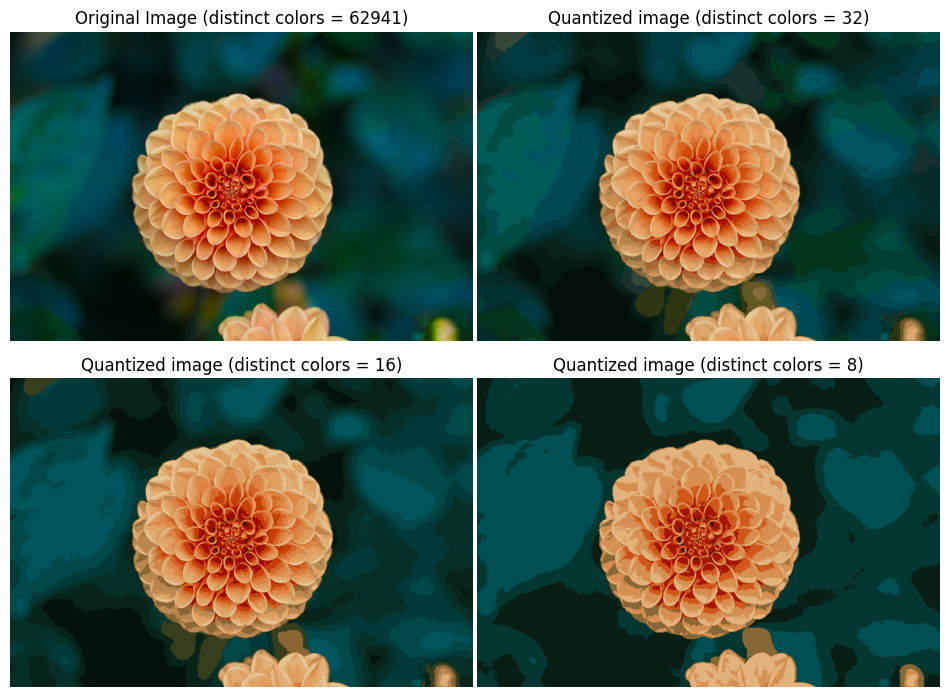

In [9]:
img = load_sample_image("flower.jpg")
dist_color = get_distinct_colours(img)
fig = plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title(f"Original Image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img)

k = 32
img_k32 = color_quantization(img, k)
dist_color = get_distinct_colours(img_k32)
plt.subplot(2, 2, 2)
plt.title(f"Quantized image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img_k32)

k = 16
img_k16 = color_quantization(img, k)
dist_color = get_distinct_colours(img_k16)
plt.subplot(2, 2, 3)
plt.title(f"Quantized image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img_k16)

k = 8
img_k8 = color_quantization(img, k)
dist_color = get_distinct_colours(img_k8)
plt.subplot(2, 2, 4)
plt.title(f"Quantized image (distinct colors = {dist_color})")
plt.axis('off')
plt.imshow(img_k8)
plt.subplots_adjust(wspace=0.01, hspace=-0.4)
# plt.savefig("image_Quantized.svg", format="svg", transparent=True, bbox_inches='tight')
plt.savefig("image_Quantized.png", format="png", transparent=True, bbox_inches='tight')
plt.show()